In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("bigdata1.csv", sep=";")

data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
data.head()

,Twits,Valence,Arousal,Dominance
0,_Bayramov Məndə bayaq 5 butılka Korona və bir ...,3.61,2.42,3.13
1,Sana all korona,3.66,2.90,3.35
2,thinkin about getting into a new historical se...,3.68,2.40,3.24
3,Gariban korona mı içer amına koyduğum,3.19,2.67,2.97
4,Xaricdən Zolotoy Korona ilə bu hesaba yollaya ...,3.43,2.38,3.09


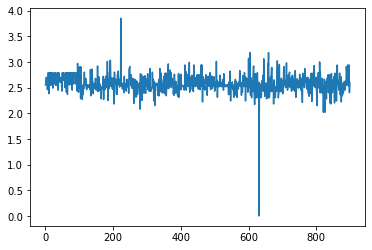

In [2]:
data_train = data.iloc[30:-100,1:]
data_target = data.iloc[-100:,1:]

dA = data.iloc[30:-100, 2].values
dA
plt.plot(dA, label="Arousal")
plt.show()

In [3]:
dA = dA.reshape(-1,1)

In [4]:
def batching(data, seq_length):
    x, y = [], []
    
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    
    return np.array(x), np.array(y)
        
normalizer = MinMaxScaler()
training_data = normalizer.fit_transform(dA)
seq_length = 100
x, y = batching(training_data, seq_length)

print(x.shape, y.shape)

train_size = int(len(y)*0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

(799, 100, 1) (799, 1)


In [6]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [17]:
num_epochs = 200
learning_rate = 0.01
input_size = 1
hidden_size = 100
num_layers = 1
num_classes = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

losses = []
for i in range(1, num_epochs+1):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if i%10 == 0:
        print("epch: ", i, " || loss function: ", loss.item())

epch:  10  || loss function:  0.1448323279619217
epch:  20  || loss function:  0.015097678638994694
epch:  30  || loss function:  0.0063725123181939125
epch:  40  || loss function:  0.004200692288577557
epch:  50  || loss function:  0.003214885713532567
epch:  60  || loss function:  0.002767354715615511
epch:  70  || loss function:  0.0026215501129627228
epch:  80  || loss function:  0.0025785102043300867
epch:  90  || loss function:  0.0025671154726296663
epch:  100  || loss function:  0.0025634937919676304
epch:  110  || loss function:  0.0025622087996453047
epch:  120  || loss function:  0.002561644185334444
epch:  130  || loss function:  0.002561375731602311
epch:  140  || loss function:  0.0025612530298531055
epch:  150  || loss function:  0.0025612066965550184
epch:  160  || loss function:  0.00256119342520833
epch:  170  || loss function:  0.0025611903984099627
epch:  180  || loss function:  0.0025611883029341698
epch:  190  || loss function:  0.002561185508966446
epch:  200  ||

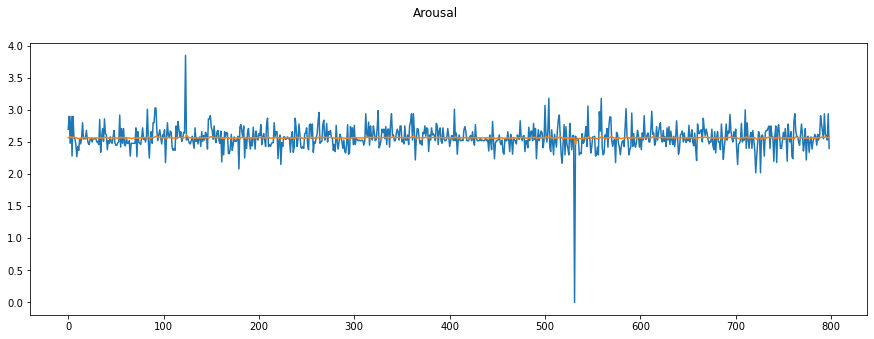

In [18]:
lstm.eval()
train_predict = lstm(dataX)
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = normalizer.inverse_transform(data_predict)
dataY_plot = normalizer.inverse_transform(dataY_plot)

#plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot, label="actual")
plt.plot(data_predict, label="prediction")
plt.suptitle("Arousal")
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()

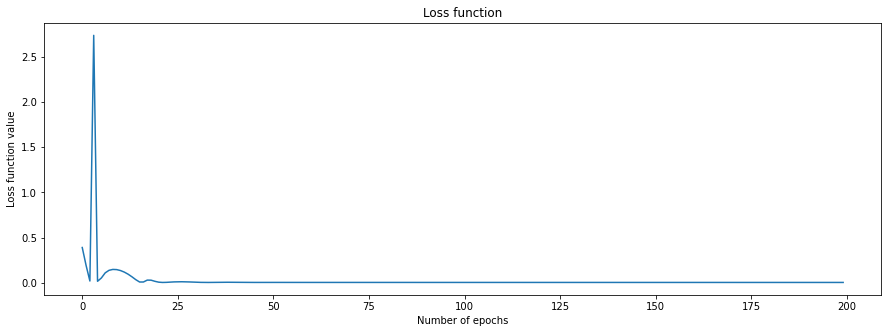

In [19]:
plt.plot(losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss function value")
plt.title("Loss function")
plt.show()

In [20]:
data_predict

array([[2.5682387],
       [2.571724 ],
       [2.5799496],
       [2.5679052],
       [2.578983 ],
       [2.5607238],
       [2.576329 ],
       [2.570317 ],
       [2.5668266],
       [2.5625381],
       [2.553804 ],
       [2.556285 ],
       [2.5547488],
       [2.5605023],
       [2.5596871],
       [2.5623393],
       [2.5727055],
       [2.567465 ],
       [2.565605 ],
       [2.5652962],
       [2.5698948],
       [2.5667067],
       [2.5628865],
       [2.5608695],
       [2.563383 ],
       [2.564146 ],
       [2.562463 ],
       [2.5637481],
       [2.564293 ],
       [2.5644524],
       [2.5645347],
       [2.562752 ],
       [2.5624666],
       [2.5605083],
       [2.5740364],
       [2.5603125],
       [2.5636137],
       [2.5704396],
       [2.5653248],
       [2.5761855],
       [2.5721056],
       [2.5697842],
       [2.5607514],
       [2.5625079],
       [2.5615432],
       [2.5645113],
       [2.562624 ],
       [2.5611727],
       [2.5640597],
       [2.56915  ],
